In [9]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import custom modules
from src.models.bert_model import TrollDetector
from src.models.trainer import TrollDetectorTrainer
from src.data_tools.dataset import TrollDataset, collate_batch

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [9]:
# Define paths
DATA_DIR = Path('data')
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
CHECKPOINT_DIR = Path('./checkpoints')

# Create checkpoint directory
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Updated training configuration
config = {
    # Model configuration
    # 'model_name': 'distilbert-base-multilingual-cased',
    'adapter_path': None, #Dont use adapter for first training
    'model_name': 'ufal/robeczech-base',

    # Data parameters
    'max_length': 96,
    'batch_size': 2,

    # Training hyperparameters
    'learning_rate': 1e-5,
    'weight_decay': 0.01,
    'num_epochs': 6,
    'dropout_rate': 0.2,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,
    'comments_per_user': 10,
    
    # Training control
    'early_stopping_patience': 3,
    'random_state': 17,
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"{key}: {value}")

Configuration loaded:
adapter_path: None
model_name: ufal/robeczech-base
max_length: 96
batch_size: 2
learning_rate: 1e-05
weight_decay: 0.01
num_epochs: 6
dropout_rate: 0.2
warmup_steps: 0
max_grad_norm: 1.0
comments_per_user: 10
early_stopping_patience: 3
random_state: 17


In [ ]:
from src.data_tools.czech_data_tools import load_czech_media_data

DATA_DIR = Path('./data')
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

# # Read the processed Czech media comments from parquet file
# czech_comments = pd.read_parquet("data/processed/czech_media_comments.parquet")
# print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

INFO:src.data_tools.czech_data_tools:Found 124 JSON files to process
Loading files: 100%|██████████████████████████████████████████████████████████████████| 124/124 [00:12<00:00,  9.70it/s]


Loaded 845743 comments from 66588 unique authors


In [ ]:
# # # Load preprocessed data splits
# # train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train.parquet')
# # val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val.parquet')
# # test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test.parquet')

# # # Load preprocessed small data splits
# train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train_en_only.parquet')
# val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val_en_only.parquet')
# test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test_en_only.parquet')

# print("Dataset sizes:")
# print(f"Train: {len(train_df)} samples, {train_df['author'].nunique()} authors")
# print(f"Val:   {len(val_df)} samples, {val_df['author'].nunique()} authors")
# print(f"Test:  {len(test_df)} samples, {test_df['author'].nunique()} authors")

Dataset sizes:
Train: 85039 samples, 3319 authors
Val:   18378 samples, 711 authors
Test:  17723 samples, 712 authors


In [3]:
train_df = pd.read_csv('./data/fewshot_czech_comments.csv')

In [4]:
from sklearn.model_selection import train_test_split
# Split train_df into new train and validation sets (e.g., 80% train, 20% val)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,           # 20% for validation
    random_state=config['random_state'],
    stratify=train_df['label'] if 'label' in train_df.columns else None  # Optional: stratify if you have class labels
)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")

Train set: 46 samples
Validation set: 12 samples


In [10]:
train_dataset = TrollDataset(
    train_df,
    tokenizer_name=config['model_name'],
    max_length=config['max_length'],
    comments_per_user=config['comments_per_user'],
    label_column='label',  
    normalize_labels=True
)

val_dataset = TrollDataset(
    val_df,
    tokenizer_name=config['model_name'],
    max_length=config['max_length'],
    comments_per_user=config['comments_per_user'],
    label_column='label',
    normalize_labels=True
)

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_batch
)

INFO:src.data_tools.dataset:Labels are already normalized between 0 and 1
Creating samples: 100%|██████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 32145.62it/s]
INFO:src.data_tools.dataset:Created 46 samples from 46 authors
INFO:src.data_tools.dataset:Labels are already normalized between 0 and 1
Creating samples: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15684.53it/s]
INFO:src.data_tools.dataset:Created 12 samples from 12 authors


In [11]:
# Initialize Model and Trainer
model = TrollDetector(
    model_name=config['model_name'],
    adapter_path=config['adapter_path'],
    dropout_rate=config['dropout_rate']
)

# Initialize trainer
trainer = TrollDetectorTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=None,
    learning_rate=config['learning_rate'],
    weight_decay=config['weight_decay'],
    max_grad_norm=config['max_grad_norm'],
    num_epochs=config['num_epochs'],
    warmup_steps=config['warmup_steps'],
    checkpoint_dir=CHECKPOINT_DIR,
)

INFO:adapters.heads.model_mixin:Adding head 'default' with config {'head_type': 'masked_lm', 'vocab_size': 51997, 'embedding_size': 768, 'layers': 2, 'activation_function': 'gelu', 'layer_norm': True, 'bias': True, 'shift_labels': False, 'label2id': None}.
Some weights of RobertaAdapterModel were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Train the model
final_metrics = trainer.train()

print("\nTraining completed!")

# Save final configuration and results
results = {
    'config': config,
    'final_metrics': final_metrics
}

with open(CHECKPOINT_DIR / 'training_results.json', 'w') as f:
    json.dump(results, f, indent=2)

INFO:src.models.trainer:Starting training...
INFO:src.models.trainer:
Epoch 1/6
Evaluating: 100%|████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it, loss=0.7310]
INFO:src.models.trainer:Train metrics: {'mse': 0.16485744093178384, 'rmse': 0.4060264042298036, 'mae': 0.3365399338628935, 'r2': -0.05309689060122169, 'binary_accuracy': 0.2826086956521739, 'loss': 0.7077313842980758}
INFO:src.models.trainer:Val metrics: {'mse': 0.14998335316779432, 'rmse': 0.38727684305648113, 'mae': 0.3092007537682851, 'r2': -0.04084833041746405, 'binary_accuracy': 0.25, 'loss': 0.7014628748099009}
INFO:src.models.trainer:Saved best model with R² score: -0.0408
INFO:src.models.trainer:
Epoch 2/6
Evaluating: 100%|████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it, loss=0.7072]
INFO:src.models.trainer:Train metrics: {'mse': 0.15997059937858876, 'rmse': 0.39996324753480633, 'mae': 0.32823840625908063, 'r2': -0.021880115577642023, 'bin


Best epoch: 5
Best validation metrics:
loss: 0.6905
mse: 0.1445
rmse: 0.3802
mae: 0.2988
r2: -0.0030
binary_accuracy: 0.3333

Training completed!

Final metrics:


TypeError: unsupported format string passed to dict.__format__

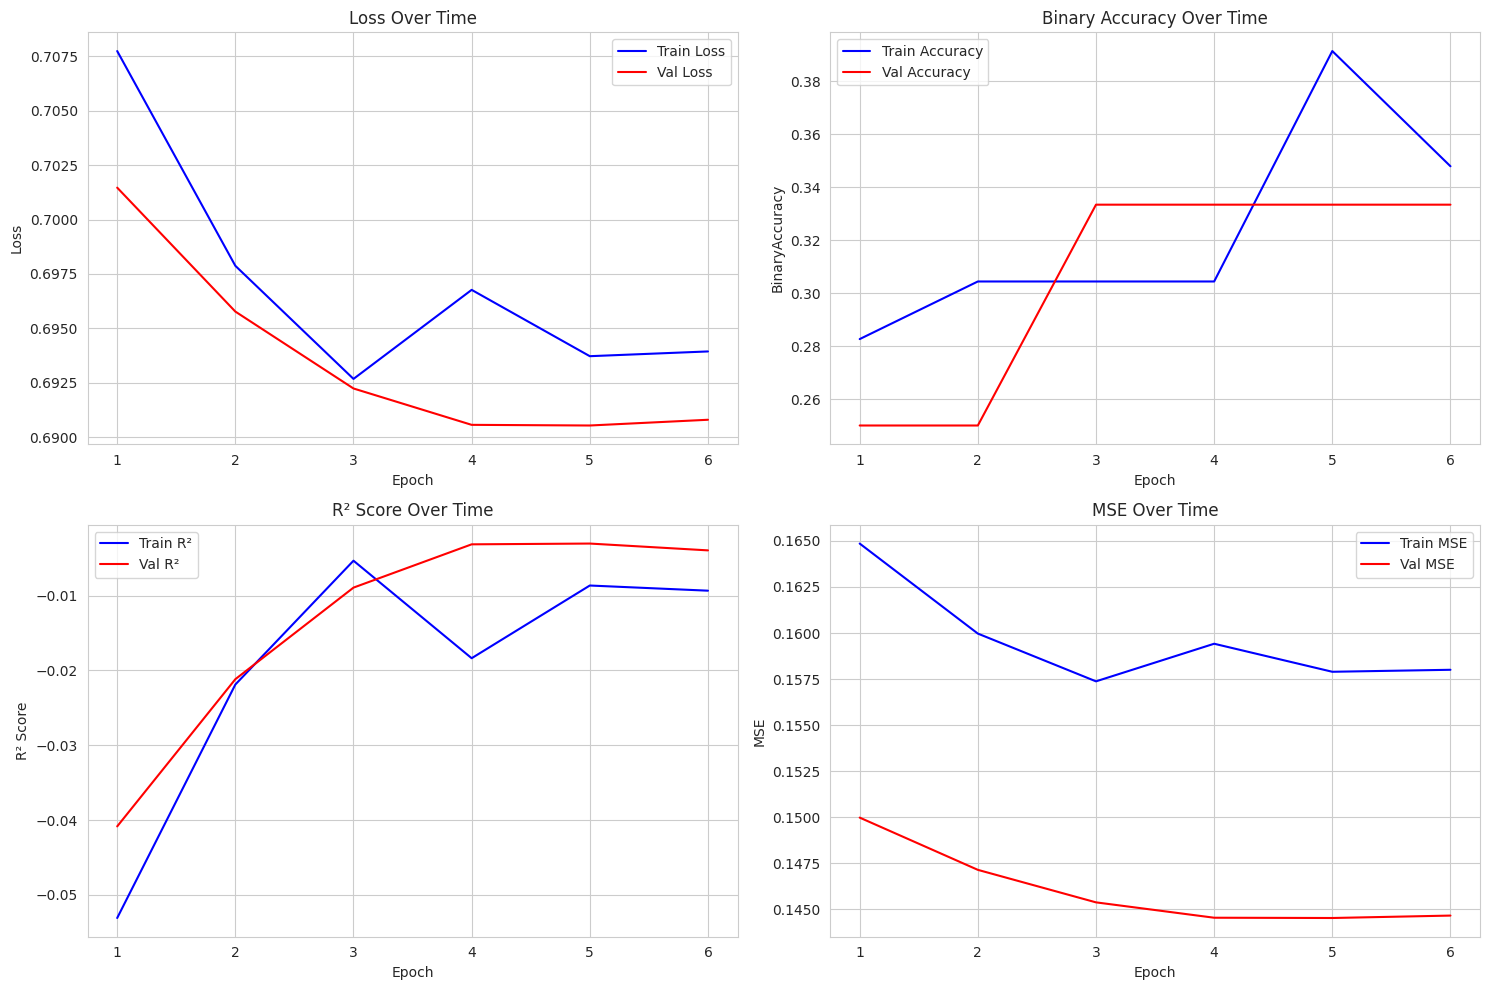

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(trainer):
    """
    Plot training history from the trainer object.
    
    Args:
        trainer: TrollDetectorTrainer instance
        save_path: Optional path to save the plot
    """
    history = trainer.history
    
    # Set style
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Create x-axis values starting at 1
    epochs = list(range(1, len(history['train']['loss']) + 1))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train']['loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history['val']['loss'], label='Val Loss', color='red')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train']['binary_accuracy'], label='Train Accuracy', color='blue')
    plt.plot(epochs, history['val']['binary_accuracy'], label='Val Accuracy', color='red')
    plt.title('Binary Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('BinaryAccuracy')
    plt.legend()
    
    # Plot R² score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train']['r2'], label='Train R²', color='blue')
    plt.plot(epochs, history['val']['r2'], label='Val R²', color='red')
    plt.title('R² Score Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.legend()
    
    # Plot MSE
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train']['mse'], label='Train MSE', color='blue')
    plt.plot(epochs, history['val']['mse'], label='Val MSE', color='red')
    plt.title('MSE Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    
    plt.tight_layout()
    
    plt.show()

# After training is complete, you can call:
plot_training_history(trainer)

In [8]:
# Get the best epoch index
best_epoch = trainer.best_epoch

# Get the metrics for the best epoch
best_metrics = {metric: trainer.history['val'][metric][best_epoch] for metric in trainer.history['val']}

print(f"Best epoch: {best_epoch + 1}")
print("Best validation metrics:")
for k, v in best_metrics.items():
    print(f"{k}: {v:.4f}")

best_train_metrics = {metric: trainer.history['train'][metric][best_epoch] for metric in trainer.history['train']}

print("\nTraining metrics at best epoch:")
for k, v in best_train_metrics.items():
    print(f"{k}: {v:.4f}")

Best epoch: 2
Best validation metrics:
loss: 0.2385
mse: 0.0653
rmse: 0.2555
mae: 0.1279
r2: 0.7116
binary_accuracy: 0.9170

Training metrics at best epoch:
loss: 0.2550
mse: 0.0669
rmse: 0.2586
mae: 0.1432
r2: 0.7174
binary_accuracy: 0.9131


In [14]:
# Save the final model state
final_model_path = CHECKPOINT_DIR / 'robeczech_first_model.pt'
torch.save(model.state_dict(), final_model_path)
print(f"\nSaved final model to: {final_model_path}")



Saved final model to: checkpoints/robeczech_first_model.pt


In [10]:
# Save the final model state with all necessary information
checkpoint = {
    'epoch': trainer.best_epoch, 
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'scheduler_state_dict': trainer.scheduler.state_dict(),
    'metrics': {
        'test': final_metrics
    },
    'best_val_r2': trainer.best_val_r2, 
    'best_epoch': trainer.best_epoch
}

# Save the checkpoint
final_model_path = CHECKPOINT_DIR / 'best_model_final_BCE_checkpoint_13.pt'
torch.save(checkpoint, final_model_path)
print(f"\nSaved checkpoint to: {final_model_path}")

# Also save the configuration and metrics separately for easy reference
config = {
    'model_name': config['model_name'],
    'best_epoch': trainer.best_epoch,
    'best_metrics': {
        'validation_r2': trainer.best_val_r2,
        'test_metrics': final_metrics
    }
}

with open(CHECKPOINT_DIR / 'best_model_final_info.json', 'w') as f:
    json.dump(config, f, indent=4)
print(f"Saved model info to: {CHECKPOINT_DIR / 'best_model_final_info.json'}")


Saved checkpoint to: checkpoints/best_model_final_BCE_checkpoint_13.pt
Saved model info to: checkpoints/best_model_final_info.json
